In [1]:
# Import necessary libraries and define the data loading function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import math
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import requests

# Set Random Seed and Device Configuration
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Check if CUDA (GPU) is available and select the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(torch.version.cuda)
torch.cuda.empty_cache()

print("torch.cuda.device_count():", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Using device: cuda
12.4
torch.cuda.device_count(): 4
Device 0: NVIDIA RTX A5500
Device 1: NVIDIA RTX A5500
Device 2: NVIDIA RTX A5500
Device 3: NVIDIA RTX A5500


In [2]:
# Data loader: tiny Shakespeare dataset
def load_shakespeare_data(sequence_length=20, batch_size=128):
    """
    Downloads the tiny Shakespeare dataset, encodes it at character-level,
    and creates DataLoaders for training (80%) and validation (20%).
    """
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    response = requests.get(url)
    text = response.text
    
    # Create a character-integer mapping
    chars = sorted(list(set(text)))
    char_to_int = {ch: i for i, ch in enumerate(chars)}
    int_to_char = {i: ch for i, ch in enumerate(chars)}
    vocab_size = len(chars)
    
    # Encode text and create sequences and targets
    encoded_text = [char_to_int[ch] for ch in text]
    sequences = []
    targets = []
    for i in range(0, len(encoded_text) - sequence_length):
        seq = encoded_text[i : i + sequence_length]
        target = encoded_text[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    
    # Create a dataset class
    class CharDataset(Dataset):
        def __init__(self, seqs, targs):
            self.seqs = seqs
            self.targs = targs
        def __len__(self):
            return len(self.seqs)
        def __getitem__(self, idx):
            return self.seqs[idx], self.targs[idx]
    
    dataset = CharDataset(sequences, targets)
    
    # Split into train/test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
    
    return train_loader, test_loader, vocab_size, int_to_char

In [3]:
# Model definitions (LSTM & GRU) with adjustable HYPERPARAMETERS
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=1):
        super(ShakespeareLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        last_output = output[:, -1, :]
        logits = self.fc(last_output)
        return logits

class ShakespeareGRU(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=1):
        super(ShakespeareGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        last_output = output[:, -1, :]
        logits = self.fc(last_output)
        return logits

In [4]:
# Positional Encoding (used by the transformer model)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x shape: (batch, seq_length, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [5]:
# Transformer-based model for Shakespeare (for next character prediction)
class ShakespeareTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=2, nhead=2, dropout=0.1):
        """
        Transformer model with adjustable number of layers and heads.
        embed_size: Dimension for embeddings (and d_model)
        hidden_size: Dimension for the feed-forward layer in the transformer encoder
        """
        super(ShakespeareTransformer, self).__init__()
        self.embed_size = embed_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size, 
            nhead=nhead, 
            dim_feedforward=hidden_size, 
            dropout=dropout, 
            batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)
    
    def forward(self, x):
        # x shape: (batch, seq_length)
        x = self.embedding(x) * math.sqrt(self.embed_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        logits = self.fc(x[:, -1, :])  # Predict using the last token's representation
        return logits

In [6]:
# Utility functions: count parameters, training, and evaluation routines
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_one_epoch(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    running_loss = 0.0
    total_samples = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        total_samples += batch_x.size(0)
    epoch_loss = running_loss / total_samples
    return epoch_loss

def evaluate(model, loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    correct = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
    epoch_loss = running_loss / total_samples
    accuracy = correct / total_samples
    return epoch_loss, accuracy

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    elapsed = time.time() - start_time
    print(f"Training completed in {elapsed:.2f} seconds")
    return train_losses, val_losses, val_accuracies, elapsed

In [7]:
# Experiments
# 1) Run LSTM & GRU for seq_length=20 and seq_length=30, then compare.
# 2) Adjust hyperparameters (e.g., hidden_size, num_layers) to see the effects.
# 3) Increase sequence length to 50 and observe the results.

def run_experiment(sequence_length, model_type='LSTM', embed_size=128, hidden_size=128, 
                   num_layers=1, nhead=2, epochs=10, lr=0.001, batch_size=128, device='cpu'):
    """
    Runs an experiment on the tiny Shakespeare dataset with the specified configuration.
    Returns training logs and performance metrics.
    """
    # Load data
    train_loader, test_loader, vocab_size, int_to_char = load_shakespeare_data(
        sequence_length=sequence_length, 
        batch_size=batch_size
    )
    
    # Initialize model based on model_type
    if model_type == 'LSTM':
        model = ShakespeareLSTM(vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)
    elif model_type == 'GRU':
        model = ShakespeareGRU(vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers)
    elif model_type == 'Transformer':
        model = ShakespeareTransformer(vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, nhead=nhead)
    else:
        raise ValueError("model_type must be 'LSTM', 'GRU', or 'Transformer'")
    
    param_count = count_parameters(model)
    print(f"\nRunning {model_type} with seq_length={sequence_length}, embed_size={embed_size}, hidden_size={hidden_size}, layers={num_layers}, nhead={nhead} | Params: {param_count}")
    
    train_losses, val_losses, val_accuracies, training_time = train_model(
        model, train_loader, test_loader, epochs=epochs, lr=lr, device=device
    )
    
    return {
        'model_type': model_type,
        'sequence_length': sequence_length,
        'embed_size': embed_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'nhead': nhead if model_type == 'Transformer' else None,
        'param_count': param_count,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'training_time': training_time
    }

In [8]:
# Experiments: Run baseline experiments and hyperparameter variations.
# For comparison, run experiments for LSTM, GRU, and Transformer models.
epochs = 20
lr = 0.001
hidden_size = 128
embed_size = 128
batch_size = 128

results = []

# Baseline experiments for seq_length=20 and seq_length=30
# LSTM, seq_length=20
res_lstm_SL20 = run_experiment(sequence_length=20, model_type='LSTM', embed_size=embed_size, hidden_size=hidden_size, num_layers=1, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_lstm_SL20)

# GRU, seq_length=20
res_gru_SL20 = run_experiment(sequence_length=20, model_type='GRU', embed_size=embed_size, hidden_size=hidden_size, num_layers=1, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_gru_SL20)

# Transformer, seq_length=20 (default: 2 layers, 2 heads)
res_trans_SL20 = run_experiment(sequence_length=20, model_type='Transformer', embed_size=embed_size, hidden_size=hidden_size, num_layers=2, nhead=2, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_trans_SL20)

# LSTM, seq_length=30
res_lstm_SL30 = run_experiment(sequence_length=30, model_type='LSTM', embed_size=embed_size, hidden_size=hidden_size, num_layers=1, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_lstm_SL30)

# GRU, seq_length=30
res_gru_SL30 = run_experiment(sequence_length=30, model_type='GRU', embed_size=embed_size, hidden_size=hidden_size, num_layers=1, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_gru_SL30)

# Transformer, seq_length=30
res_trans_SL30 = run_experiment(sequence_length=30, model_type='Transformer', embed_size=embed_size, hidden_size=hidden_size, num_layers=2, nhead=2, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_trans_SL30)

# Hyperparameter adjustments for Transformer: explore 1, 2, and 4 layers with 2 and 4 heads (8 combinations)
hp_results = []
for layers in [1, 2, 4]:
    for heads in [2, 4]:
        res = run_experiment(sequence_length=20, model_type='Transformer', embed_size=embed_size, hidden_size=hidden_size, num_layers=layers, nhead=heads, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
        hp_results.append(res)
        results.append(res)

# Increase sequence length to 50 for Transformer model
res_trans_SL50 = run_experiment(sequence_length=50, model_type='Transformer', embed_size=embed_size, hidden_size=hidden_size, num_layers=2, nhead=2, epochs=epochs, lr=lr, batch_size=batch_size, device=device)
results.append(res_trans_SL50)


Running LSTM with seq_length=20, embed_size=128, hidden_size=128, layers=1, nhead=2 | Params: 148801
Epoch 1/20, Train Loss: 1.8342, Val Loss: 1.6405, Val Acc: 0.5107
Epoch 2/20, Train Loss: 1.5808, Val Loss: 1.5528, Val Acc: 0.5316
Epoch 3/20, Train Loss: 1.5131, Val Loss: 1.5088, Val Acc: 0.5446
Epoch 4/20, Train Loss: 1.4756, Val Loss: 1.4906, Val Acc: 0.5481
Epoch 5/20, Train Loss: 1.4511, Val Loss: 1.4710, Val Acc: 0.5528
Epoch 6/20, Train Loss: 1.4319, Val Loss: 1.4544, Val Acc: 0.5573
Epoch 7/20, Train Loss: 1.4174, Val Loss: 1.4450, Val Acc: 0.5595
Epoch 8/20, Train Loss: 1.4056, Val Loss: 1.4389, Val Acc: 0.5621
Epoch 9/20, Train Loss: 1.3959, Val Loss: 1.4329, Val Acc: 0.5637
Epoch 10/20, Train Loss: 1.3878, Val Loss: 1.4304, Val Acc: 0.5625
Epoch 11/20, Train Loss: 1.3810, Val Loss: 1.4245, Val Acc: 0.5637
Epoch 12/20, Train Loss: 1.3749, Val Loss: 1.4195, Val Acc: 0.5660
Epoch 13/20, Train Loss: 1.3694, Val Loss: 1.4200, Val Acc: 0.5654
Epoch 14/20, Train Loss: 1.3648, Val

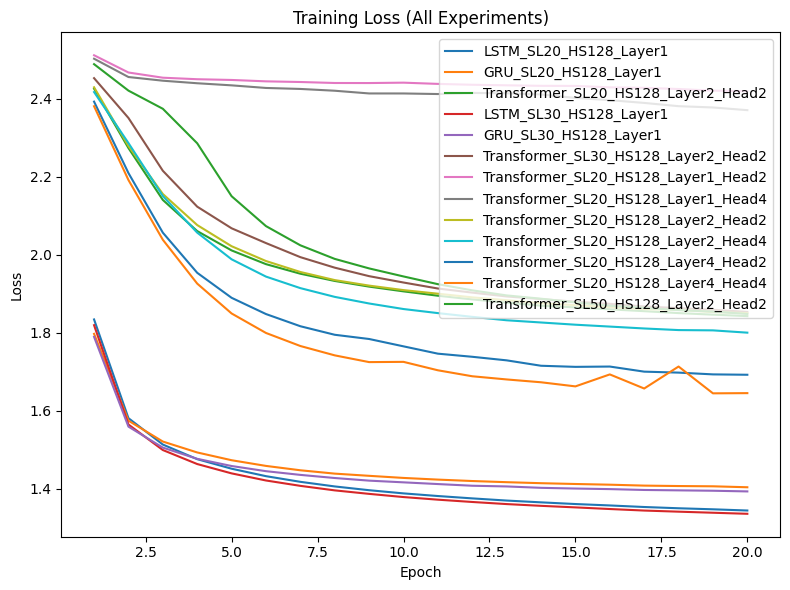

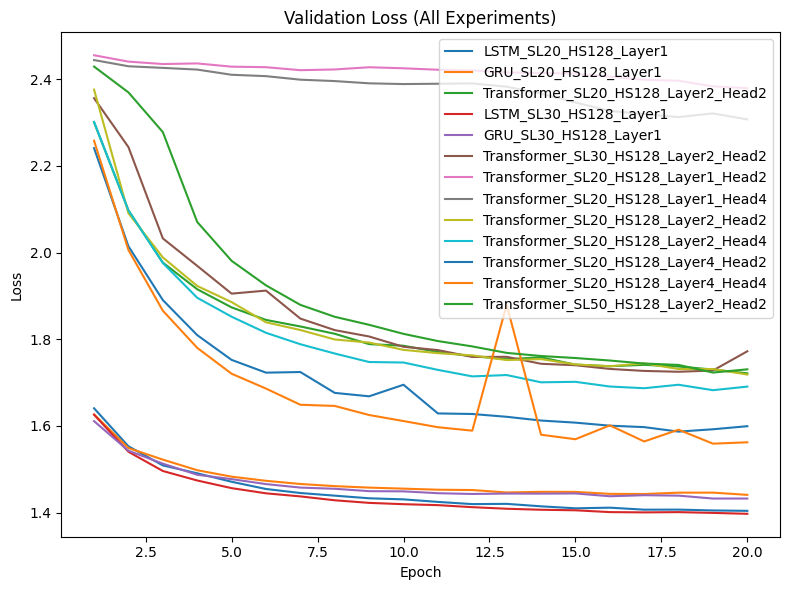

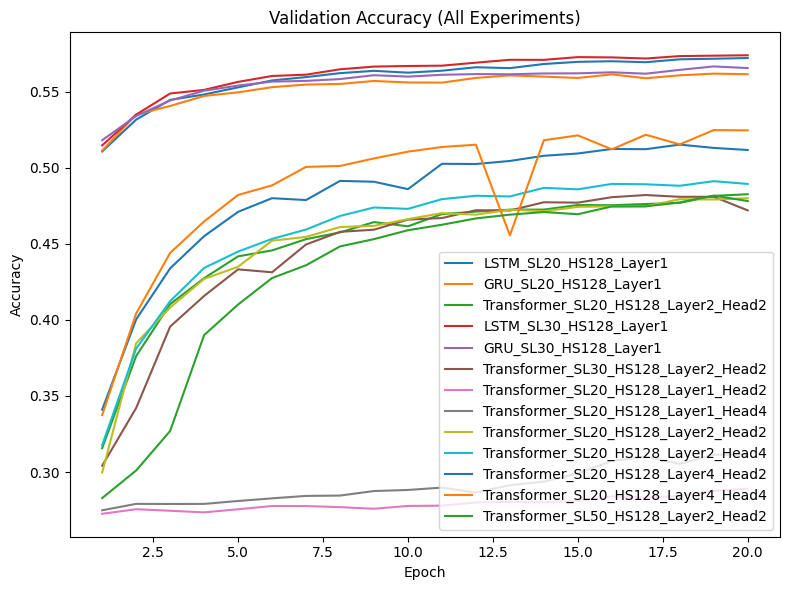

In [9]:
# Plotting functions for training and validation metrics (saving images with new names)
def plot_metric(results_list, key, title, ylabel, filename):
    plt.figure(figsize=(8,6))
    for r in results_list:
        epochs_range = range(1, len(r[key]) + 1)
        label = f"{r['model_type']}_SL{r['sequence_length']}_HS{r['hidden_size']}_Layer{r['num_layers']}"
        if r['model_type'] == 'Transformer':
            label += f"_Head{r['nhead']}"
        plt.plot(epochs_range, r[key], label=label)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"images/hw5_p2_{filename}.png")
    plt.show()

# Plot training loss for all experiments
plot_metric(results, key='train_losses', title='Training Loss (All Experiments)', ylabel='Loss', filename='train_loss')

# Plot validation loss for all experiments
plot_metric(results, key='val_losses', title='Validation Loss (All Experiments)', ylabel='Loss', filename='val_loss')

# Plot validation accuracy for all experiments
plot_metric(results, key='val_accuracies', title='Validation Accuracy (All Experiments)', ylabel='Accuracy', filename='val_accuracy')

In [10]:
# Summary table of experiments
print("\nSUMMARY OF EXPERIMENTS:")
print("Model         | SeqLen | Embed | Hidden | Layers | Heads  |   Params   | Final Train Loss | Final Val Loss | Final Val Acc | Training Time (s)")
for r in results:
    final_train_loss = r['train_losses'][-1]
    final_val_loss = r['val_losses'][-1]
    final_val_acc = r['val_accuracies'][-1]
    training_time = r['training_time']
    heads_str = f"{r['nhead']}" if r['model_type'] == 'Transformer' else "-"
    print(f"{r['model_type']:<13s} | {r['sequence_length']:^6d} | {r['embed_size']:^5d} | {r['hidden_size']:^6d} | {r['num_layers']:^6d} | {heads_str:^6s} | {r['param_count']:^10d} | {final_train_loss:^16.4f} | {final_val_loss:^14.4f} | {final_val_acc:^13.4f} | {training_time:^16.2f}")


SUMMARY OF EXPERIMENTS:
Model         | SeqLen | Embed | Hidden | Layers | Heads  |   Params   | Final Train Loss | Final Val Loss | Final Val Acc | Training Time (s)
LSTM          |   20   |  128  |  128   |   1    |   -    |   148801   |      1.3438      |     1.4039     |    0.5721     |      173.50     
GRU           |   20   |  128  |  128   |   1    |   -    |   115777   |      1.4035      |     1.4408     |    0.5614     |      162.81     
Transformer   |   20   |  128  |  128   |   2    |   2    |   215873   |      1.8427      |     1.7212     |    0.4826     |      359.00     
LSTM          |   30   |  128  |  128   |   1    |   -    |   148801   |      1.3354      |     1.3971     |    0.5739     |      204.21     
GRU           |   30   |  128  |  128   |   1    |   -    |   115777   |      1.3928      |     1.4323     |    0.5655     |      176.13     
Transformer   |   30   |  128  |  128   |   2    |   2    |   215873   |      1.8535      |     1.7721     |    0.4720    